In [1]:
import torch
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#--- hyperparameters ---
N_EPOCHS = 10
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 100
LR = 0.01

In [3]:
#--- fixed constants ---
NUM_CLASSES = 24
DATA_DIR = '../data/sign_mnist_%s'

In [4]:
# --- Dataset initialization ---

# We transform image files' contents to tensors
# Plus, we can add random transformations to the training data if we like
# Think on what kind of transformations may be meaningful for this data.
# Eg., horizontal-flip is definitely a bad idea for sign language data.
# You can use another transformation here if you find a better one.
train_transform = transforms.Compose([
                                        #transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.ImageFolder(DATA_DIR % 'train', transform=train_transform)
dev_set   = datasets.ImageFolder(DATA_DIR % 'dev',   transform=test_transform)
test_set  = datasets.ImageFolder(DATA_DIR % 'test',  transform=test_transform)


# Create Pytorch data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE_TEST, shuffle=False)

torch.Size([3, 28, 28])
tensor([[[0.0000, 0.7373, 0.7412,  ..., 0.6980, 0.6902, 0.6824],
         [0.6784, 0.7451, 0.7412,  ..., 0.7059, 0.7020, 0.6941],
         [0.6941, 0.7490, 0.7451,  ..., 0.7098, 0.7098, 0.7020],
         ...,
         [0.7412, 0.2824, 0.2863,  ..., 0.3451, 0.3569, 0.3647],
         [0.3647, 0.3216, 0.3216,  ..., 0.2392, 0.2392, 0.2471],
         [0.2118, 0.3137, 0.3098,  ..., 0.2784, 0.2745, 0.2275]],

        [[0.0000, 0.7373, 0.7412,  ..., 0.6980, 0.6902, 0.6824],
         [0.6784, 0.7451, 0.7412,  ..., 0.7059, 0.7020, 0.6941],
         [0.6941, 0.7490, 0.7451,  ..., 0.7098, 0.7098, 0.7020],
         ...,
         [0.7412, 0.2824, 0.2863,  ..., 0.3451, 0.3569, 0.3647],
         [0.3647, 0.3216, 0.3216,  ..., 0.2392, 0.2392, 0.2471],
         [0.2118, 0.3137, 0.3098,  ..., 0.2784, 0.2745, 0.2275]],

        [[0.0000, 0.7373, 0.7412,  ..., 0.6980, 0.6902, 0.6824],
         [0.6784, 0.7451, 0.7412,  ..., 0.7059, 0.7020, 0.6941],
         [0.6941, 0.7490, 0.7451, 

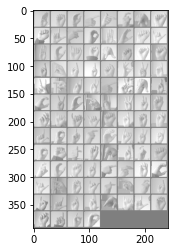

In [5]:
# look at loaded data, first batch; train set
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

image,label=train_set[0]
print(image.shape) #torch.Size([3, 28, 28])
print(image)
  
dataiter=iter(train_loader)
images,labels=next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [6]:
#--- model ---
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        # WRITE CODE HERE
                # input tensor of size BATCH SIZE TRAIN x NUM CHANNELS x WIDTH x HEIGHT
        #                                       x       3      X  28   x   28
        # Layers
        self.layer1 = nn.Sequential(
            # first set of CONV => RELU => CONV => RELU =>POOL layers
            nn.Conv2d(3,28,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(28,56,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(    
            # second set of CONV => RELU => CONV => RELU =>POOL layers
            nn.Conv2d(56,112,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(112,112,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.layer_out = nn.Sequential(
            # outer layer
            # maybe add fully connected layers? 
            nn.Flatten(),
            nn.Linear(112*4*4,448),
            nn.ReLU(),
            nn.Linear(448,224),
            nn.ReLU(),
            nn.Linear(224,num_classes))
            # guess we could also consider using softmax classifier? 
        
    # Initialize weights?

    def forward(self, x):
        # WRITE CODE HERE
        # pass the input through the layers 
        x = self.layer1
        x = self.layer2
        x = self.layer_out
        
        return x

In [ ]:
#--- set up ---
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = CNN().to(device)

# WRITE CODE HERE
# try different optimizers - feel free to change
optimizers = [optim.SGD(model.parameters(), lr=LR), 
              optim.Adamax(model.parameters(), lr=LR),
              optim.Adam(model.parameters(), lr=LR)]
optimizer = optimizers[0]

# try different loss functions - feel free to change
loss_functions = [nn.NLLLoss(), nn.CrossEntropyLoss(), nn.MultiLabelMarginLoss()]
loss_function = loss_functions[0]

# use early stopping as a regularization technique
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
    # the class method early_stop returns True if the error has grown more than min_delta
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper()  # feel free to experiment with different class parameters


#--- training ---
for epoch in range(N_EPOCHS):
    train_loss = 0
    train_correct = 0
    total = 0
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # WRITE CODE HERE

        print('Training: Epoch %d - Batch %d/%d: Loss: %.4f | Train Acc: %.3f%% (%d/%d)' % 
              (epoch, batch_num, len(train_loader), train_loss / (batch_num + 1), 
               100. * train_correct / total, train_correct, total))
    
    # WRITE CODE HERE
    # Please implement early stopping here.
    # You can try different versions, simplest way is to calculate the dev error and
    # compare this with the previous dev error, stopping if the error has grown.

    # evaluate model
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for x,y in dev_set:
            out = model(x)
            validation_loss += loss_function(out, y)
    # total loss
    validation_loss /= len(dev_set)

    # turn model back to training
    model.train()

    if early_stopper.early_stop(validation_loss):
        break


In [ ]:
#--- test ---
test_loss = 0
test_correct = 0
total = 0

with torch.no_grad():
    for batch_num, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        # WRITE CODE HERE

        print('Evaluating: Batch %d/%d: Loss: %.4f | Test Acc: %.3f%% (%d/%d)' % 
              (batch_num, len(test_loader), test_loss / (batch_num + 1), 
               100. * test_correct / total, test_correct, total))
